In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.utils import shuffle
from matplotlib.lines import Line2D
import seaborn as sns

In [157]:
a = np.load('/home/vvinod/2024/QeMFi/dataset/QeMFi_acrolein.npz',allow_pickle=True)['DPn']

In [118]:
def KRR(X_train,X_test,y_train,y_test,sigma,reg=1e-10):
    from qml.math import cho_solve
    from qml.kernels import matern_kernel
    
    K_train = matern_kernel(X_train,X_train,sigma=sigma,order=1, metric='l2')
    K_train[np.diag_indices_from(K_train)]+=reg
    K_test = matern_kernel(X_train,X_test,sigma=sigma,order=1, metric='l2')
    
    alpha = cho_solve(K_train,y_train)
    
    preds = np.dot(alpha,K_test)
    mae = np.mean(np.abs(preds-y_test))
    
    return mae

In [119]:
def gridsearch(sigs):
    from sklearn.model_selection import train_test_split
    X = np.load('raws/X_train_CM.npy')
    y = np.load('raws/energies.npy',allow_pickle=True)[-1]
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,train_size=0.8)
    X_train = X_train[:1000]
    y_train = y_train[:1000]
    X_test = X_test[:200]
    y_test = y_test[:200]
    
    maes = []
    for s in sigs:
        m_t = KRR(X_train,X_test,y_train,y_test,sigma=s,reg=1e-10)
        maes.append(m_t)
    plt.plot(sigs,maes,marker='o')
    print(sigs[np.argmin(maes)],np.min(maes))

3222.222222222222 0.07982176252317806


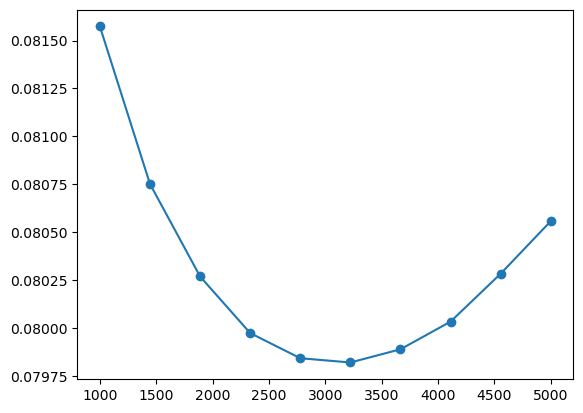

In [121]:
sigs = np.linspace(1000,5000,10)
gridsearch(sigs)

* SCF - 150.0
* EV - 20.0
* EV1 - 20.0
* DPe - 3000.0
* DPn - 3000.0

In [141]:
def lc_test(s):
    from tqdm.notebook import tqdm
    X = np.load('raws/X_train_CM.npy')[:2**12]
    y = np.load('raws/energies.npy',allow_pickle=True)[-1][:2**12]
    
    X_test = np.load('raws/X_test_CM.npy')
    y_test = np.load('raws/y_test.npy')
    
    maes = []
    for i in tqdm(range(1,12)):
        temp = KRR(X[:2**i],X_test,y[:2**i],y_test,sigma=s,reg=1e-10)
        maes.append(temp)
    return np.asarray(maes)

In [142]:
m20 = lc_test(3000.0)
#m150 = lc_test(150.0)

  0%|          | 0/11 [00:00<?, ?it/s]

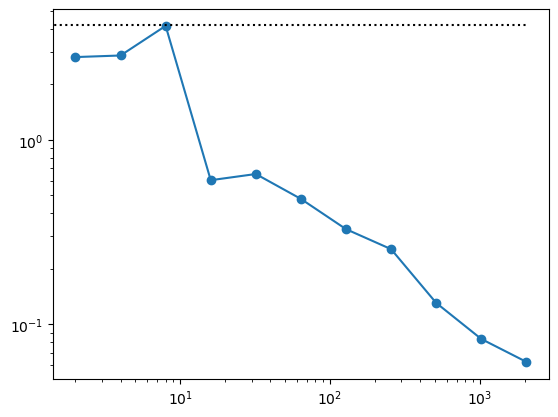

In [143]:
plt.loglog(2**np.arange(1,12),m20,marker='o')
#plt.loglog(2**np.arange(1,12),m150,marker='s')
test = np.load('raws/y_test.npy')
plt.hlines(test.std(),xmin=0,xmax=2**11,color='k',linestyle=':')

In [144]:
y_trains = np.load('raws/energies.npy',allow_pickle=True)

0.6128150932377564 18.523793027951918 4.217057440464414
0.6128150932377564 18.523793027951918 4.217057440464414
0.6128150932377564 18.523793027951918 4.217057440464414
0.6128150932377564 18.523793027951918 4.217057440464414
0.6128150932377564 18.523793027951918 4.217057440464414


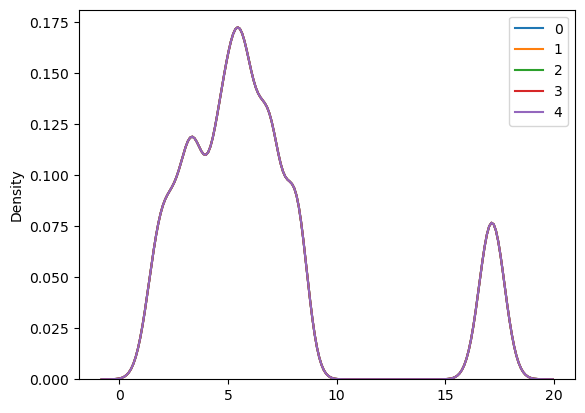

In [145]:
for i in range(5):
    sns.kdeplot(data=y_trains[i],label=str(i))
    print(y_trains[i].min(),y_trains[i].max(),y_trains[i].std())
plt.legend()

In [134]:
trdpnorm = np.linalg.norm(temp_data,axis=2)
trdpnorm.shape

(15000, 5)

<Axes: ylabel='Density'>

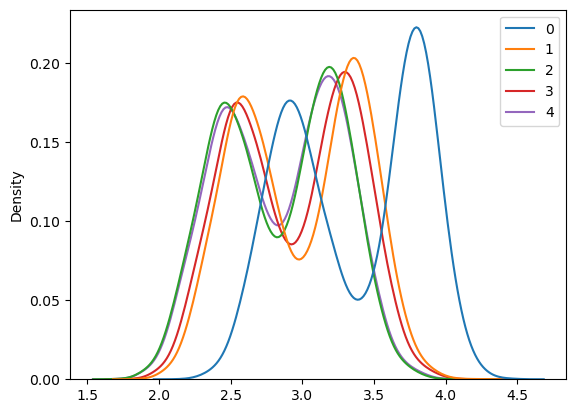

In [135]:
sns.kdeplot(trdpnorm)

To Do:
* all energies in kcal/mol
* TrDP, fosc - bad results
* First vertical excitation, second vertical excitation 
* 1 au = 630 kcal/mol
* 1 $\rm cm^{-1}$ = 0.0029 kcal/mol

In [3]:
mult=1#0.0029

# Prep Data

In [149]:
def data_prep():
    molnames = ['urea','acrolein','alanine','sma','nitrophenol','urocanic','dmabn','thymine','o-hbdi']
    #idx = np.arange(0,15000)
    #idx = shuffle(idx,random_state=42)
    #idx=idx[:6000] #why?
    
    X=np.zeros((135000,253),dtype=float) 
    y_all = np.zeros((135000,5),dtype=float)
    
    start=0
    end=15000
    idx_names = np.zeros((135000),dtype=float)
    for i,m in enumerate(molnames):
        names = np.full(15000,i)
        idx_names[start:end] = np.copy(names)
        temp_data=np.load(f'/home/vvinod/2024/QeMFi/dataset/QeMFi_{m}.npz')['DPe']#[:,:,0,:]
        #print(temp_data.shape)
        #for trdp
        temp_data = np.linalg.norm(temp_data,axis=2)
        #print(temp_data.shape)
        #['SCF'] # in hE #the property of interest can be changed here
        #['TrDP'][:,:,0,:] with np.linalg.norm(temp_data,axis=2)
        #['fosc'][:,:,0]
        #['EV'][:,:,0]
        temp_X = np.load(f'/home/vvinod/2024/QeMFi/MFML/Reps/{m}_CM.npy')
        y_all[start:end,:] = temp_data
        X[start:end,:temp_X.shape[-1]] = temp_X
        #increment for next molecule
        start += 15000
        end += 15000
    y_new = np.zeros((5),dtype=object)
    
    X,idx_names = shuffle(X,idx_names,random_state=42)
    y_train = np.zeros((5),dtype=object) #STO3G first
    for i in range(5):
        y_all[:,i] = shuffle(y_all[:,i],random_state=42)
        y_new[i] = y_all[:,i]
        y_train[i] = y_new[i][:54000]
    
    X_train = X[:54000,:]
    X_val = X[54000:55000,:]
    y_val = y_new[-1][54000:55000] #TZVP
    X_test = X[55000:,:]
    y_test = y_new[-1][55000:] #TZVP
    
    y_val_SVP = y_new[3][54000:55000]
    y_val_631 = y_new[2][54000:55000]
    y_val_321 = y_new[1][54000:55000]
    y_val_STO = y_new[0][54000:55000]
    
    y_test_SVP = y_new[3][55000:]
    y_test_631 = y_new[2][55000:]
    y_test_321 = y_new[1][55000:]
    y_test_STO = y_new[0][55000:]
    
    np.save('raws/X_train_CM.npy',X_train)
    np.save('raws/X_test_CM.npy',X_test)
    np.save('raws/X_val_CM.npy',X_val)
    np.save('raws/energies.npy',y_train,allow_pickle=True)
    np.save('raws/y_test.npy',y_test)
    
    np.save('raws/y_lower_SVP.npy',y_test_SVP)
    np.save('raws/y_lower_631G.npy',y_test_631)
    np.save('raws/y_lower_321G.npy',y_test_321)
    np.save('raws/y_lower_STO3G.npy',y_test_STO)
    
    np.save('raws/y_val_SVP.npy',y_val_SVP)
    np.save('raws/y_val_631G.npy',y_val_631)
    np.save('raws/y_val_321G.npy',y_val_321)
    np.save('raws/y_val_STO3G.npy',y_val_STO)
    
    np.save('raws/y_val.npy',y_val)
    np.save('raws/idx_names.npy',idx_names)
    
    #save index file for MFML 
    indexes = np.zeros((5),dtype=object)
    temp = np.arange(0,54000)
    for i in range(5):
        indexes[i] = np.vstack([temp,temp]).T
    np.save('raws/indexes.npy',indexes,allow_pickle=True)
    

In [150]:
data_prep()

In [154]:
def data_distr(ax=None):
    ax = ax or plt.gca()
    full_idx = np.load('raws/idx_names.npy')
    train_idx = full_idx[:54000]
    val_idx = full_idx[54000:55000]
    test_idx = full_idx[55000:]
    
    colors = plt.cm.binary(np.linspace(0,1,4))[1:]
    
    ax.hist([train_idx,test_idx,val_idx],bins=9,stacked=False,log=True,color=colors)
    ax.legend(['train','test','val'],bbox_to_anchor=(1,1))
    ax.set_xticks([0,1,2,3,4,5,6,7,8],
               ['urea','acrolein','alanine',
                'SMA','2-nitrophenol','urocanic',
                'DMABN','thymine','o-HBDI'],
               rotation=45)
    ax.set_ylabel('Number of geometries')

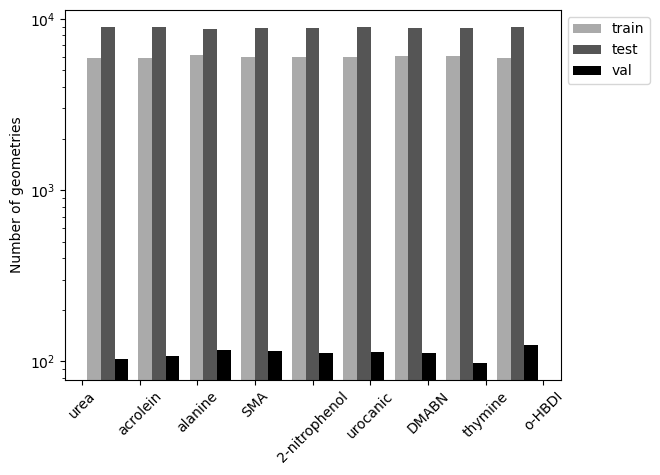

In [155]:
data_distr()
plt.savefig('updatedplots/distr_hist.pdf',format='pdf',bbox_inches='tight',dpi=150.0)

In [5]:
np.load('outs/EV_delML_STO3G_mae.npy')

array([3807.67051292, 3350.14565057, 3415.69176818, 2735.66589654,
       2049.28693083, 1731.30023275, 1447.63625446, 1251.81216058,
        985.96392481,  744.11924304,  600.52084639])

# $\Delta$ ML

In [126]:
delMLs = np.load(f'outs/DPn_delML_STO3G_mae.npy')

In [146]:
np.load('raws/energies.npy',allow_pickle=True)[0]

array([7.17965255, 1.55111403, 6.84358383, ..., 3.36667651, 7.85448942,
       6.27323569])

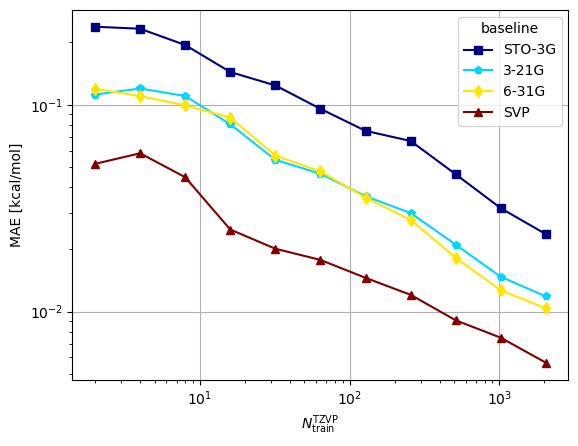

In [151]:
def delMLLCs(ax=None):
    ax = ax or plt.gca()
    fids = ['STO3G','321G','631G','SVP']
    labels = ['STO-3G','3-21G','6-31G','SVP']
    
    colors=plt.cm.jet(np.linspace(0,1,4))#[:-1]
    markers = ['s','p','d','^']
    
    for i in range(4):
        delMLs = np.load(f'outs/DPe_delML_{fids[i]}_mae.npy')*mult
        #delMLs1 = np.load(f'outs/TrDP_delML_{fids[i]}_mae.npy')*mult
        #delMLs2 = np.load(f'outs/EV2_delML_{fids[i]}_mae.npy')
        n = 2**np.arange(1,1+delMLs.shape[0])
        ax.loglog(n,delMLs,label=f'{labels[i]}',marker=markers[i],color=colors[i])
        #ax.loglog(n,delMLs1,label=f'{labels[i]}'+str(2500),linestyle='--',marker=markers[i],color=colors[i])
        #ax.loglog(n,delMLs2,label=f'{labels[i]}'+str(2),linestyle=':',marker=markers[i],color=colors[i])
    #test = np.load('raws/y_test.npy')
    #ax.hlines(test.std()*mult,xmin=0,xmax=2**11,color='k',linestyle='--',label='std')
    ax.legend(title='baseline')
    ax.set_ylabel('MAE [kcal/mol]')
    ax.set_xlabel('$N_{\mathrm{train}}^{\mathrm{TZVP}}$')
    ax.grid()
    
delMLLCs()
#plt.loglog(2**np.arange(1,12),m20,marker='o')
#plt.loglog(2**np.arange(1,12),m150,marker='s')
#test = np.load('raws/y_test.npy')*mult
#plt.hlines(test.std(),xmin=0,xmax=2**11,color='k',linestyle=':')
#plt.savefig('plots/delta_LC_comparison.pdf',format='pdf',bbox_inches='tight',dpi=150.0)

Key take-away:
   * the closer the fidelity to target fidelity, the lower the error
   * difference of almost an order of magnitude between STO3G and def2-SVP

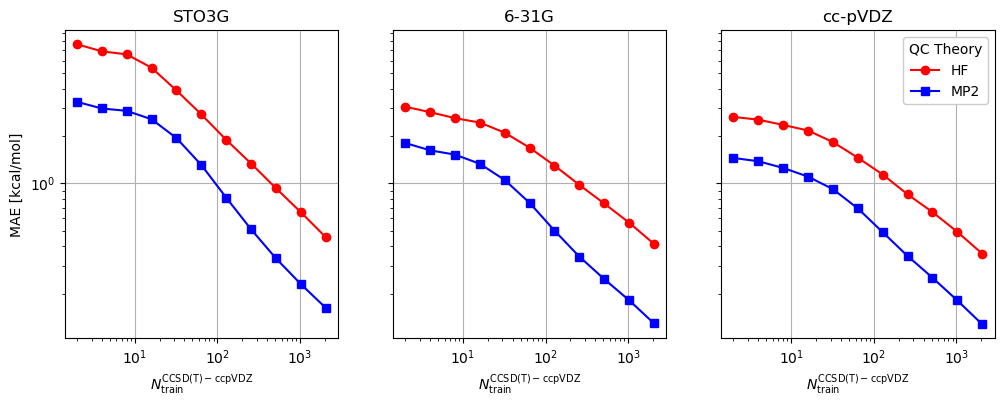

In [48]:
def QM7b_delta_ML():
    sto3g = np.load('QM7bRaws/DelMAE_sto3g.npy',allow_pickle=True)
    g631 = np.load('QM7bRaws/DelMAE_631g.npy',allow_pickle=True)
    pvdz = np.load('QM7bRaws/DelMAE_ccpvdz.npy',allow_pickle=True)
    
    n = 2**np.arange(1,12)
    
    color=['r','b']
    fig,ax = plt.subplots(1,3,figsize=(12,4),sharey=True)
    
    ax[0].set_title('STO3G')
    ax[1].set_title('6-31G')
    ax[2].set_title('cc-pVDZ')
    
    ax[0].loglog(n,sto3g[0],color=color[0],marker='o',label='HF')
    ax[0].loglog(n,sto3g[1],color=color[1],marker='s',label='MP2')
   
    ax[0].set_ylabel('MAE [kcal/mol]')
    
    ax[1].loglog(n,g631[0],color=color[0],marker='o',label='HF')
    ax[1].loglog(n,g631[1],color=color[1],marker='s',label='MP2')
    
    ax[2].loglog(n,pvdz[0],color=color[0],marker='o',label='HF')
    ax[2].loglog(n,pvdz[1],color=color[1],marker='s',label='MP2')
    ax[2].legend(title='QC Theory',framealpha=1.0)
    for i in range(3):
        ax[i].grid()
        ax[i].set_xlabel('$N_{\mathrm{train}}^{\mathrm{CCSD(T)-ccpVDZ}}$')
    
QM7b_delta_ML()    
plt.savefig('plots/DelML_QM7b.pdf',format='pdf',bbox_inches='tight',dpi=150.0)

# MFML

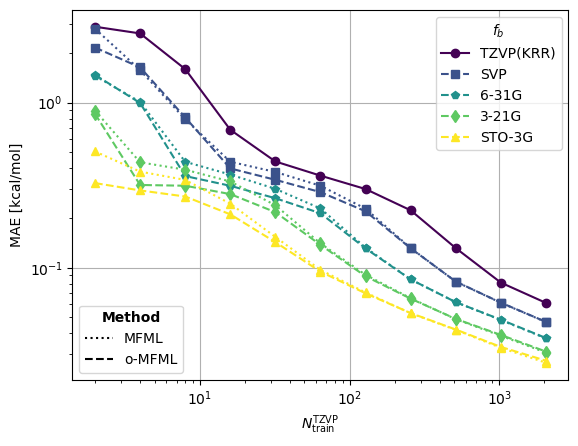

In [152]:
def MFML_LC(ax=None):
    ax = ax or plt.gca()
    def_mae = np.load('outs/DPe_defaultMAEs.npy',allow_pickle=True)*mult
    OLS_mae = np.load('outs/DPe_OLSMAEs.npy',allow_pickle=True)*mult
    n = 2**np.arange(1,1+def_mae[1].shape[0])
    fids = ['STO3G','321G','631G','SVP','TZVP']
    labels = ['STO-3G','3-21G','6-31G','SVP']
    
    colors=plt.cm.viridis(np.linspace(0,1,5))#[:-1]
    markers = ['o','s','p','d','^']
    
    ax.loglog(n,def_mae[0],marker=markers[0],linestyle='-',label='TZVP(KRR)',color=colors[0]) 
    
    for i in range(1,5):
        ax.loglog(n,def_mae[i],marker=markers[i],linestyle=':',color=colors[i])
        ax.loglog(n,OLS_mae[i],marker=markers[i],linestyle='--',label=labels[4-i],color=colors[i])
    ax.set_ylabel('MAE [kcal/mol]')
    ax.set_xlabel('$N_{\mathrm{train}}^{\mathrm{TZVP}}$')
    color_legend = ax.legend(title='$f_b$',loc='upper right')
    
    style_lines = [Line2D([0], [0], color='black', linestyle=':', label='MFML'),
                   Line2D([0], [0], color='black', linestyle='--', label='o-MFML')
                  ]
    style_legend = ax.legend(handles=style_lines, title='Method', loc='lower left',title_fontproperties={'weight': 'bold'})
    ax.add_artist(color_legend)
    ax.grid()
MFML_LC()
#plt.savefig('plots/MFML_LCs.pdf',format='pdf',bbox_inches='tight',dpi=150.0)

Key take-away:
* MFML and o-MFML perform similarly

# MF$\Delta$ML

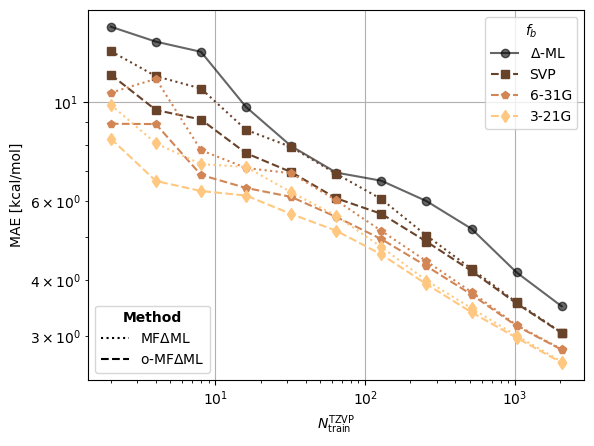

In [88]:
def MFDeltaML_LC(ax=None):
    ax = ax or plt.gca()
    def_mae = np.load('outs/EV2_Delta_defaultMAEs_STO3G.npy',allow_pickle=True)[1:]*mult
    OLS_mae = np.load('outs/EV2_Delta_OLSMAEs_STO3G.npy',allow_pickle=True)[1:]*mult
    delsto = np.load('outs/EV2_delML_STO3G_mae.npy')*mult
    n = 2**np.arange(1,1+def_mae[1].shape[0])
    
    fids = ['STO3G','321G','631G','SVP','TZVP']
    labels = ['STO-3G','3-21G','6-31G','SVP']
    
    colors=plt.cm.copper(np.linspace(0,1,4))#[:-1]
    markers = ['s','p','d','^']
    
    ax.loglog(n,delsto,marker='o',linestyle='-',label='$\Delta$-ML',color=colors[0],alpha=0.6)
    
    for i in range(3):
        ax.loglog(n,def_mae[i],marker=markers[i],color=colors[i+1],linestyle=':')
        ax.loglog(n,OLS_mae[i],marker=markers[i],color=colors[i+1],linestyle='--',label=labels[3-i])
    ax.set_ylabel('MAE [kcal/mol]')
    ax.set_xlabel('$N_{\mathrm{train}}^{\mathrm{TZVP}}$')
    color_legend = ax.legend(title='$f_b$',loc='upper right')
    
    style_lines = [Line2D([0], [0], color='black', linestyle=':', label='MF$\Delta$ML'),
                   Line2D([0], [0], color='black', linestyle='--', label='o-MF$\Delta$ML')
                  ]
    style_legend = ax.legend(handles=style_lines, title='Method', loc='lower left',title_fontproperties={'weight': 'bold'})
    ax.add_artist(color_legend)
    #ax.set_title('Learning Curves\nMF$\Delta$-ML and o-MF$\Delta$ML')
    ax.grid()
MFDeltaML_LC()
#plt.savefig('plots/MFDeltaML_LCs.pdf',format='pdf',bbox_inches='tight',dpi=150.0)

# Time vs MAE

In [89]:
def return_train_times():
    all_times = np.zeros((9,5),dtype=float)
    molnames = ['urea','acrolein','alanine','sma',
                'nitrophenol','urocanic',
                'dmabn','thymine','o-hbdi']
    for i in range(9): #loop over molecules in QeMFi
        all_times[i,:] = np.load(f'../QeMFi/dataset/QeMFi_{molnames[i]}.npz',
                                 allow_pickle=True)['t']
    return all_times

def time_cost(n_trains=None, all_times=None):
    if type(n_trains)==type(None):
        n_trains = np.asarray([32, 16, 8, 4, 2])
    if type(all_times)==type(None):
        all_times = return_train_times()
    n_trains=np.asarray(n_trains)
    train_idx = np.load('raws/idx_names.npy')
    train_idx = train_idx.astype(dtype=int) 
    train_idx = train_idx[:n_trains.max()]
    
    train_times = all_times[train_idx,:]

    train_cost = 0
    for i in range(5):
        train_cost += train_times[:n_trains[i],i].sum()
    
    return train_cost

In [90]:
def combined_time_comparison_plot(ax=None, colors=None):
    ax = ax or plt.gca()
    
    if type(colors)==type(None):
        colors = plt.cm.viridis(np.linspace(0,1,10))
    train_idx = np.load('raws/idx_names.npy')
    train_idx = train_idx.astype(dtype=int) 
    test_idx = np.copy(train_idx[55000:])
    val_idx = np.copy(train_idx[54000:55000])
    
    all_times = return_train_times()
    
    val_time = all_times[val_idx,-1].sum()/60.0
    test_sto_time = all_times[test_idx,0].sum()/60.0 #*12.5 #for hypothetical 1 million geometries in test set

    
    
    #default MFML - only sto3g
    #OLS MFML - only sto3g
    sf_mae = np.load('outs/EV2_defaultMAEs.npy',allow_pickle=True)[0]*mult
    def_mae = np.load('outs/EV2_defaultMAEs.npy',allow_pickle=True)[-1]*mult
    OLS_mae = np.load('outs/EV2_OLSMAEs.npy',allow_pickle=True)[-1]*mult
    
    
    #delta MFML versions
    del_def_mae = np.load('outs/EV2_Delta_defaultMAEs_STO3G.npy',allow_pickle=True)[-1]*mult
    del_OLS_mae = np.load('outs/EV2_Delta_OLSMAEs_STO3G.npy',allow_pickle=True)[-1]*mult
    delsto = np.load('outs/EV2_delML_STO3G_mae.npy')*mult
    
    sf_time = []
    del_ML_time = []
    MFML_time = []
    del_MFML_time = []
    for i in range(1,12):
        sf_time.append(time_cost(n_trains=[0,0,0,0,2**(i)], all_times=all_times))
        del_ML_time.append(time_cost(n_trains=[2**(i),0,0,0,2**(i)], all_times=all_times))
        MFML_time.append(time_cost(n_trains=[2**(i+4),2**(i+3),2**(i+2),2**(i+1),2**(i)], all_times=all_times))
        del_MFML_time.append(time_cost(n_trains=[2**(i+3),2**(i+3),2**(i+2),2**(i+1),2**(i)], all_times=all_times))
    sf_time = np.asarray(sf_time)/60.0
    del_ML_time = np.asarray(del_ML_time)/60.0
    MFML_time = np.asarray(MFML_time)/60.0
    del_MFML_time = np.asarray(del_MFML_time)/60.0
    
    ax.loglog(sf_time,sf_mae,marker='o',
              label='KRR(TZVP)',color=colors[0],linestyle=':')
    ax.loglog(MFML_time, def_mae, marker='s',
              label='MFML(STO-3G)',color=colors[1],linestyle='-')
    ax.loglog(MFML_time+val_time, OLS_mae, marker='d',
              label='o-MFML(STO-3G)',color=colors[2],linestyle=':')
    
    ax.loglog(del_ML_time+test_sto_time, delsto, marker='+',#
              label='$\Delta$-ML(STO-3G)', color = colors[3],linestyle=':')
    ax.loglog(del_MFML_time+test_sto_time, del_def_mae,marker='^',#
              label='MF$\Delta_{\mathrm{STO-3G}}$ML(3-21G)', color = colors[4],linestyle=':')
    ax.loglog(del_MFML_time+test_sto_time+val_time, del_OLS_mae,marker='d',
              label='o-MF$\Delta_{\mathrm{STO-3G}}$ML(3-21G)', color = colors[5],linestyle=':')
    
    ax.legend(ncol=1,framealpha=1.0,fontsize=8.5)
    ax.set_xlabel('$\mathrm{T_{train-data}}$ [min]')
    ax.set_ylabel('MAE [kcal/mol]')
    ax.grid()

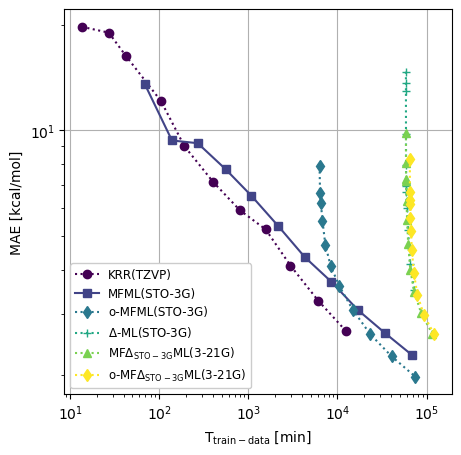

In [91]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
#viridis, tab20b, tab20
combined_time_comparison_plot(colors = plt.cm.viridis(np.linspace(0,1,6)),ax=ax)
#plt.savefig('plots/time_deltaMLs.pdf',format='pdf',bbox_inches='tight',dpi=150.0)
#plt.xlim(5e3,5e4)

# Predicted-baseline-$\Delta$-ML

2.6820501989182968
3.278476520497907
3.4960068892827447
2.282213157173759


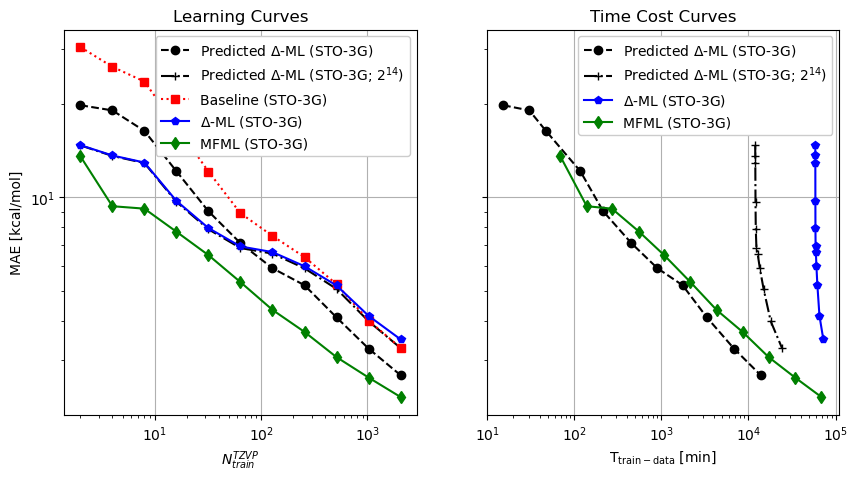

In [92]:
def predictedDelMLcomp(ax=None):
    #calculate times
    train_idx = np.load('raws/idx_names.npy')
    train_idx = train_idx.astype(dtype=int) 
    test_idx = np.copy(train_idx[55000:])
    val_idx = np.copy(train_idx[54000:55000])
    all_times = return_train_times()
    test_sto_time = all_times[test_idx,0].sum()/60.0
    del_ML_time = []
    large_del_ML_time = []
    MFML_time = []
    

    for i in range(1,12):
        del_ML_time.append(time_cost(n_trains=[2**(i),0,0,0,2**(i)], all_times=all_times))
        large_del_ML_time.append(time_cost(n_trains=[2**14,0,0,0,2**(i)], all_times=all_times))
        MFML_time.append(time_cost(n_trains=[2**(i+4),2**(i+3),2**(i+2),2**(i+1),2**(i)], all_times=all_times))
    del_ML_time = np.asarray(del_ML_time)/60.0
    MFML_time = np.asarray(MFML_time)/60.0
    large_del_ML_time = np.asarray(large_del_ML_time)/60.0
    
    ###load maes
    m = np.load('outs/EV2_predictedbase_delML_STO3G_mae.npy')*mult
    print(m[-1])
    m_2e14 = np.load('outs/EV2_predictedbase_largetraining_delML_STO3G_mae.npy')*mult
    print(m_2e14[-1]) #large number of training samples to predict lowest fidelity
    b = np.load('outs/EV2_predictedbase_delML_baseline_mae.npy')*mult
    sto3g = np.load('outs/EV2_delML_STO3G_mae.npy')*mult
    print(sto3g[-1])
    MFML_sto3g = np.load('outs/EV2_defaultMAEs.npy',allow_pickle=True)[-1]*mult
    print(MFML_sto3g[-1])
    colors = ['k','r','b','g']#plt.cm.jet(np.linspace(0,1,4))
    fig,ax = plt.subplots(1,2,figsize=(10,5),sharey=True)

    ax[0].set_title('Learning Curves')
    ax[1].set_title('Time Cost Curves')

    ax[0].loglog(2**np.arange(1,12),m,marker='o',label='Predicted $\Delta$-ML (STO-3G)',linestyle='--',color=colors[0])
    ax[0].loglog(2**np.arange(1,12),m_2e14,marker='+',label='Predicted $\Delta$-ML (STO-3G; $2^{14}$)',linestyle='-.',color=colors[0])
    ax[0].loglog(2**np.arange(1,12),b,marker='s',label='Baseline (STO-3G)', linestyle=':',color=colors[1])
    ax[0].loglog(2**np.arange(1,12),sto3g,marker='p',label='$\Delta$-ML (STO-3G)',color=colors[2])
    ax[0].loglog(2**np.arange(1,12),MFML_sto3g,marker='d', label='MFML (STO-3G)',color=colors[3])
    ax[0].legend(framealpha=1.0)
    ax[0].grid()

    ax[1].loglog(del_ML_time,m,marker='o',label='Predicted $\Delta$-ML (STO-3G)',linestyle='--',color=colors[0])
    ax[1].loglog(large_del_ML_time,m_2e14,marker='+',label='Predicted $\Delta$-ML (STO-3G; $2^{14}$)',linestyle='-.',color=colors[0]) 
    ax[1].loglog(del_ML_time+test_sto_time,sto3g,marker='p',label='$\Delta$-ML (STO-3G)',color=colors[2])
    ax[1].loglog(MFML_time,MFML_sto3g,marker='d', label='MFML (STO-3G)',color=colors[3])
    ax[1].grid()
    ax[1].legend(framealpha=1.0)
    ax[0].set_ylabel('MAE [kcal/mol]')
    ax[0].set_xlabel('$N_{train}^{TZVP}$')
    ax[1].set_xlabel('$\mathrm{T_{train-data}}$ [min]')
predictedDelMLcomp()
#plt.savefig('plots/predicteddeltaML.pdf',format='pdf',bbox_inches='tight', dpi=150.0)